# Super Simple Keras model on TriFeature for multiplicity determination

In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import (
    balanced_accuracy_score,
    confusion_matrix,
    plot_confusion_matrix,
)

sys.path.append("..")
from helpers import filename_for

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

In [2]:
import tensorflow
from tensorflow import keras

print("tensorflow", tensorflow.__version__)
print("keras", keras.__version__)

tensorflow 2.3.1
keras 2.4.0


In [3]:
num_dp = 30
max_neutrons = 4
label = "nPH"

In [4]:
files = [
    filename_for(15, 30, 600, 500, n, "inclxx", s, "trifeature.parquet")
    for n in range(1, max_neutrons + 1)
    for s in range(20)
]
dfs = [pd.read_parquet(file) for file in files]
data = pd.concat(dfs, ignore_index=True).sample(frac=1)
print(data.shape)

(800000, 6)


In [5]:
msk = np.random.rand(len(data)) < 0.8
# Create one entry with zero everything to prevent NaN-PDF if no entry with LABEL=0 exists
msk[0] = True
data.loc[0] = [0, 0, 0, 0, 0, 0]
traindata = data[msk]
testdata = data[~msk]

print(traindata.shape)
print(testdata.shape)

x_train = traindata[["nHits", "nClus", "Edep"]].values
y_train = keras.utils.to_categorical(traindata[[label]].values.ravel())

x_val = testdata[["nHits", "nClus", "Edep"]].values
y_val = keras.utils.to_categorical(testdata[[label]].values.ravel());

(639980, 6)
(160020, 6)


In [6]:
model = keras.models.Sequential()  # 24, 9 -> 81
# model.add(keras.layers.Dense(units=160, activation="relu", input_shape=(3,)))
# model.add(keras.layers.Dense(units=20, activation="relu"))
model.add(keras.layers.Dense(units=10, activation="relu"))
model.add(keras.layers.Dense(units=max_neutrons + 1, activation="softmax"))

optimizer = keras.optimizers.Adam()
loss = keras.losses.CategoricalCrossentropy()
model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])

history = model.fit(x=x_train, y=y_train, batch_size=1000, epochs=50, validation_data=(x_val, y_val), verbose=2)

Epoch 1/50
640/640 - 1s - loss: 33.4021 - accuracy: 0.2418 - val_loss: 1.3738 - val_accuracy: 0.3174
Epoch 2/50
640/640 - 1s - loss: 1.3110 - accuracy: 0.3301 - val_loss: 1.2537 - val_accuracy: 0.3328
Epoch 3/50
640/640 - 1s - loss: 1.1810 - accuracy: 0.4015 - val_loss: 0.9107 - val_accuracy: 0.6278
Epoch 4/50
640/640 - 1s - loss: 0.7260 - accuracy: 0.7551 - val_loss: 0.6521 - val_accuracy: 0.7740
Epoch 5/50
640/640 - 1s - loss: 0.6152 - accuracy: 0.7699 - val_loss: 0.5880 - val_accuracy: 0.7729
Epoch 6/50
640/640 - 1s - loss: 0.5812 - accuracy: 0.7711 - val_loss: 0.5657 - val_accuracy: 0.7743
Epoch 7/50
640/640 - 1s - loss: 0.5639 - accuracy: 0.7746 - val_loss: 0.5536 - val_accuracy: 0.7786
Epoch 8/50
640/640 - 1s - loss: 0.5553 - accuracy: 0.7767 - val_loss: 0.5485 - val_accuracy: 0.7752
Epoch 9/50
640/640 - 1s - loss: 0.5489 - accuracy: 0.7793 - val_loss: 0.5458 - val_accuracy: 0.7735
Epoch 10/50
640/640 - 1s - loss: 0.5444 - accuracy: 0.7808 - val_loss: 0.5365 - val_accuracy: 0.786

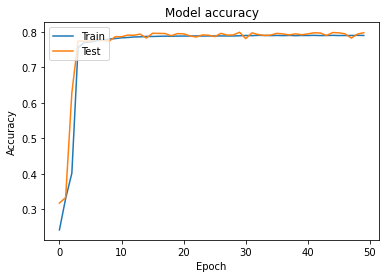

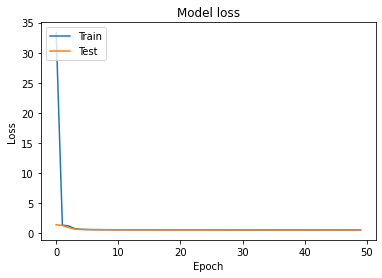

In [7]:
# Plot training & validation accuracy values
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

# Plot training & validation loss values
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

In [8]:
x_test = testdata[["nHits", "nClus", "Edep"]].values
y_true = testdata[[label]].values.ravel()

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

bac = balanced_accuracy_score(y_true, y_pred)
print(bac)
cm = confusion_matrix(y_true, y_pred, labels=range(0, max_neutrons + 1))
print(cm)
cmrel = confusion_matrix(y_true, y_pred, labels=range(0, max_neutrons + 1), normalize="true")
print(cmrel)

0.8316959079686239
[[ 2111     0     1     0     1]
 [    0 40518  1898    13     7]
 [    0  4920 31591  5241    13]
 [    0   233  6664 29606  4515]
 [    0     3   452  8487 23746]]
[[0.999 0.    0.    0.    0.   ]
 [0.    0.955 0.045 0.    0.   ]
 [0.    0.118 0.756 0.125 0.   ]
 [0.    0.006 0.162 0.722 0.11 ]
 [0.    0.    0.014 0.26  0.726]]


Text(69.0, 0.5, 'True')

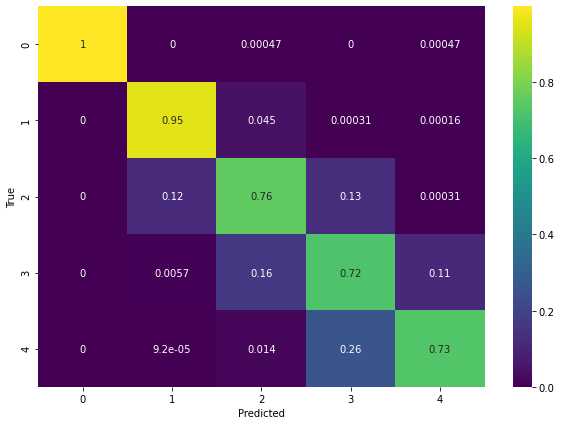

In [9]:
plt.figure(figsize=(10, 7))
ax = sns.heatmap(cmrel, cmap="viridis", annot=True)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")